In [26]:
import pandas as pd
import kaplanmeier as km
from Ensembl_converter import EnsemblConverter

# Create an instance of EnsemblConverter
converter = EnsemblConverter()

In [27]:
expression = pd.read_csv('GSE39582/GSE39582_Expression.txt', sep='\t')
expression = expression.rename(columns={'Unnamed: 0': 'SampleID'})
expression.head()

,SampleID,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000281692,ENSG00000281706,ENSG00000281732,ENSG00000281778,ENSG00000281831,ENSG00000281912,ENSG00000281937,ENSG00000282021,ENSG00000282408,ENSG00000282742
0,GSM971957,2.110198,0.297104,2.540870,0.840843,0.317806,0.647407,0.472394,1.634555,0.991131,...,-0.102991,-0.242896,0.092574,0.159464,0.014149,0.093481,-0.110161,-0.165282,-0.113612,-0.021521
1,GSM971958,2.691806,0.033531,2.760942,0.444017,0.457403,1.004509,1.551471,1.669845,1.010561,...,-0.211863,-0.300486,0.073052,0.093688,-0.148147,0.045771,-0.120700,-0.206608,-0.130290,-0.057759
2,GSM971959,2.309938,-0.148700,2.495403,0.367560,0.380946,0.312816,0.087595,1.357618,0.885281,...,-0.047195,-0.236847,0.221524,0.008524,0.004061,0.015774,-0.161790,-0.160966,0.913928,-0.049035
3,GSM971960,3.404085,0.270825,2.632237,0.618470,0.364756,0.454825,0.413661,1.618976,1.073774,...,0.008664,-0.167635,0.058125,0.137901,-0.074995,0.042816,-0.077133,-0.194407,-0.093525,-0.136959
4,GSM971961,2.245160,-0.081983,2.545356,0.617706,0.312654,1.477605,1.105855,1.552995,0.949125,...,-0.173737,-0.182521,0.063194,0.109615,-0.110598,-0.017879,-0.046757,-0.248188,-0.164532,-0.015418


In [28]:
clinical = pd.read_csv('GSE39582/GSE39582_Clinical.txt', sep='\t')
clinical.head()

,SampleID,age.at.diagnosis_year,braf.mutation,chemotherapy.adjuvant,chemotherapy.adjuvant.type,cimp.status,cin.status,cit.molecularsubtype,dataset,dependancy_sample,...,Sex,tnm.m,tnm.n,tnm.stage,tnm.t,tp53.mutation,tp53.mutation.dna,tp53.mutation.exon.number,tp53.mutation.protein,tumor.location
0,GSM971957,34.5,WT,N,NaN,-,+,C5,discovery,NaN,...,Male,M1,N2,4.0,T4,M,NaN,NaN,NaN,distal
1,GSM971958,36.4,WT,N,NaN,-,-,C4,discovery,NaN,...,Female,M1,N2,4.0,T3,WT,NaN,NaN,NaN,distal
2,GSM971959,36.9,WT,N,NaN,-,-,C3,discovery,NaN,...,Male,M0,N0,2.0,T4,M,NaN,NaN,NaN,proximal
3,GSM971960,38.2,WT,N,NaN,-,+,C1,discovery,NaN,...,Female,M0,N0,1.0,T2,M,NaN,NaN,NaN,distal
4,GSM971961,39.2,WT,Y,NaN,-,NaN,C4,discovery,NaN,...,Female,M1,N1,4.0,T3,M,NaN,NaN,NaN,distal


In [29]:
expression_sia = expression[["SampleID","ENSG00000153563", "ENSG00000173372"]]
expression_sia = expression_sia.set_axis(converter.convert_ids(expression_sia.columns.to_list())["Symbol"], axis=1)
expression_sia["SIA"] = expression_sia["CD8A"] / expression_sia["C1QA"] 
expression_sia["SIA-category"] = pd.qcut(expression_sia["SIA"], 3, labels=["Low SIA", "Intermediate SIA", "High SIA"])
expression_sia.head()


Symbol,SampleID,CD8A,C1QA,SIA,SIA-category
0,GSM971957,0.596124,1.562382,0.381548,high
1,GSM971958,0.624260,1.880654,0.331938,medium
2,GSM971959,0.097797,1.608621,0.060795,low
3,GSM971960,0.366074,1.462362,0.250331,medium
4,GSM971961,0.307417,3.331355,0.092280,low


In [30]:
survival_plot_df = expression_sia.merge(clinical, on="SampleID", how="left")
survival_plot_df = survival_plot_df[["SampleID", "SIA-category", "os.delay", "os.event"]]
survival_plot_df = survival_plot_df.dropna() # drops 4 rows
survival_plot_df.head()

,SampleID,SIA-category,os.delay,os.event
0,GSM971957,high,10.0,1.0
1,GSM971958,medium,9.0,1.0
2,GSM971959,low,52.0,0.0
3,GSM971960,medium,74.0,0.0
4,GSM971961,low,32.0,1.0


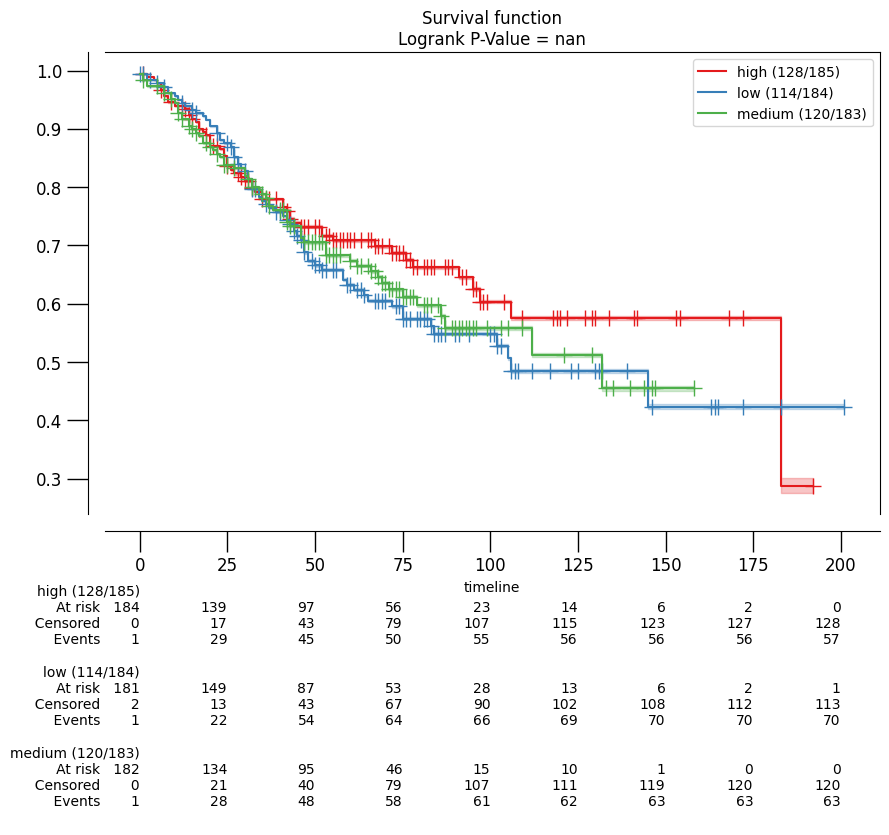

In [31]:
time_event = survival_plot_df["os.delay"]
censoring = survival_plot_df["os.event"]   
group = survival_plot_df["SIA-category"]

results = km.fit(time_event, censoring, group)
km.plot(results)